<a href="https://colab.research.google.com/github/EfrainEsquivar/Challenge-5-ALETIA/blob/main/Challenge_5_1a_Efrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib.pyplot as plt 

BicycleWeatherDF = pd.read_csv("BicycleWeather.csv", index_col='DATE', parse_dates=True)
Fremont_Bridge_Bicycle_CounterDF = pd.read_csv("Fremont_Bridge_Bicycle_Counter.csv", index_col='Date', parse_dates=True)


In [2]:
BicycleWeatherDF.head()

,STATION,NAME,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,...,WT04,WT05,WT08,WT09,WT13,WT14,WT16,WT17,WT18,WT22
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",10.51,NaN,NaN,0.00,0.0,0.0,NaN,55,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2012-01-02,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",10.07,NaN,NaN,0.43,0.0,0.0,NaN,51,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
2012-01-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",5.14,NaN,NaN,0.03,0.0,0.0,NaN,53,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2012-01-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",10.51,NaN,NaN,0.80,0.0,0.0,NaN,54,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
2012-01-05,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",13.65,NaN,NaN,0.05,0.0,0.0,NaN,48,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [3]:
Fremont_Bridge_Bicycle_CounterDF.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0


In [4]:
# Calculamos el trafico diario de bicicletas
daily = Fremont_Bridge_Bicycle_CounterDF.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]

In [5]:
# Hint: Algunos días como los fines de semana incentivan el uso de bicicleta
# Solución: Creamos las primeras 7 variables las cuales serán un ID del día de la semana
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [6]:
# Hint: Los días libres son buenos para andar en bicicleta
# Solución: Crearemos también una variable para identificar los días festivos
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

(8.0, 17.0)

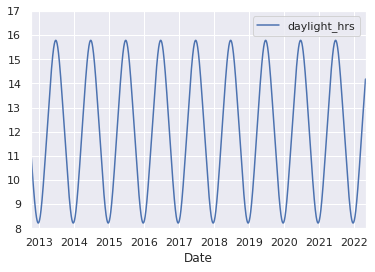

In [7]:
# Hint: Seattle es una ciudad donde el número de horas de luz en el día varían mucho durante el año
# Solución: Crearemos una variable que nos indique el número de horas de luz en el día
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [8]:
# Hint: El clima es importante cuando queremos salir a montar bicicleta
# Solución: Calculamos un promedio de temperatura por día 
# Agregamos una variable de probabilidad de lluvia
# Agregamos una variable para los días sin lluvia (es importante saber si habrá poca lluvia pero más importante saber si no habrá)

In [9]:
# Las temperaturas estan en 1/10 grados C; Convertimos los datos a grados C
BicycleWeatherDF['TMIN'] /= 10
BicycleWeatherDF['TMAX'] /= 10
BicycleWeatherDF['Temp (C)'] = 0.5 * (BicycleWeatherDF['TMIN'] + BicycleWeatherDF['TMAX'])
# La precipitación esta en 1/10 mm; Convertimos a pulgadas
BicycleWeatherDF['PRCP'] /= 254
BicycleWeatherDF['dry day'] = (BicycleWeatherDF['PRCP'] == 0).astype(int)
daily = daily.join(BicycleWeatherDF[['PRCP', 'Temp (C)', 'dry day']])

In [10]:
# Hint: El calentamiento global modifica las temperaturas cada año
# Sol: Creamos una variable "contador" que nos ayuda a dar al modelo intuición sobre el año en curso
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [11]:
# Veamos el resultado
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,5.60,1.0,0.000000
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,5.65,1.0,0.002740
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,5.95,1.0,0.005479
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,6.05,1.0,0.008219
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,6.05,1.0,0.010959


In [12]:
daily.keys()

Index(['Total', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
       'daylight_hrs', 'PRCP', 'Temp (C)', 'dry day', 'annual'],
      dtype='object')

Agrega una columna en el dataframe daily que se llame predicted y coloca en dicha columna los valores de una predicción de trafico de bicicletas.

In [13]:
daily = daily.dropna()
daily=daily.assign(Predicted=0)

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
X = daily.iloc[:,1:14]
Y = daily.iloc[:,0]

In [16]:
X

,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,
2012-10-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.000000,5.60,1.0,0.000000
2012-10-04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.000000,5.65,1.0,0.002740
2012-10-05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.000000,5.95,1.0,0.005479
2012-10-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.000000,6.05,1.0,0.008219
2012-10-07,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.000000,6.05,1.0,0.010959
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.243449,0.000197,4.20,0.0,4.235616
2016-12-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.252283,0.000000,4.25,1.0,4.238356
2016-12-29,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.262456,0.000197,4.40,0.0,4.241096


In [17]:
Y

Date
2012-10-03    14084.0
2012-10-04    13900.0
2012-10-05    12592.0
2012-10-06     8024.0
2012-10-07     8568.0
               ...   
2016-12-27     4420.0
2016-12-28     5888.0
2016-12-29     4536.0
2016-12-30     4364.0
2016-12-31     1888.0
Freq: D, Name: Total, Length: 1551, dtype: float64

In [18]:
model = LinearRegression()

In [19]:
model.fit(X,Y)

LinearRegression()

In [20]:
R_sq = model.score(X,Y)

In [21]:
R_sq

0.8627348294036449

In [22]:
model.intercept_

-2.252072914331004e+16

In [23]:
model.coef_

array([ 2.25207291e+16,  2.25207291e+16,  2.25207291e+16,  2.25207291e+16,
        2.25207291e+16,  2.25207291e+16,  2.25207291e+16, -4.59600000e+03,
        4.64750000e+02, -6.77034924e+05,  1.56150000e+03,  2.05775000e+03,
        9.82827686e+01])

In [24]:
y_pred = model.predict(X)

In [25]:
y_pred

array([14028., 13484., 12668., ...,  8384.,  6508.,   312.])

In [26]:
y_pred.shape

(1551,)

In [27]:
daily=daily.assign(Predicted=y_pred)

In [31]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,Predicted
Date,,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,5.60,1.0,0.000000,14028.0
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,5.65,1.0,0.002740,13484.0
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,5.95,1.0,0.005479,12668.0
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,6.05,1.0,0.008219,7556.0
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,6.05,1.0,0.010959,7260.0


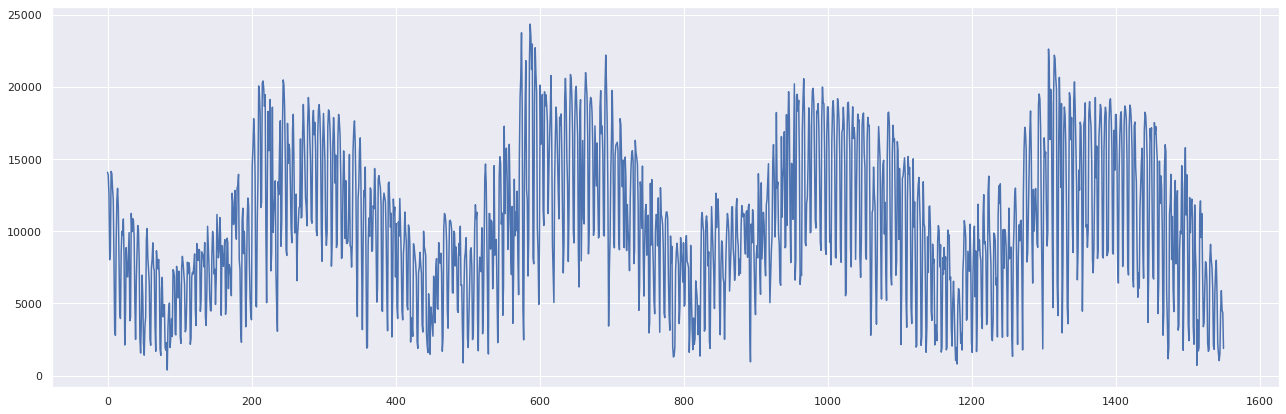

In [29]:
X_axis = list(range(X.shape[0]))
Y_axis = Y

fig, ax = plt.subplots()
ax.plot (X_axis,Y_axis, '-')
fig.set_size_inches(22,7)
plt.show()

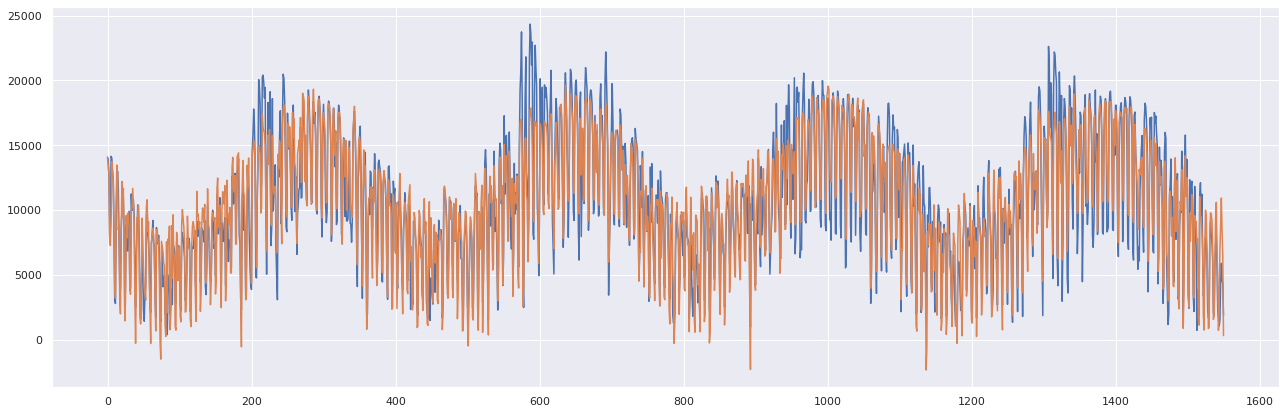

In [36]:
X_axis2 = list(range(X.shape[0]))
Y_axis2 = Y
Y2_axis2 = y_pred

fig, ax = plt.subplots()
ax.plot (X_axis2,Y_axis2, '-', X_axis2, Y2_axis2, '-')
fig.set_size_inches(22,7)
plt.show()

In [39]:
def plot_20(Y_True, Y_Pr):
    X_axis3 = list(range(20))
    Y_axis3 = Y_True[:20]
    Y2_axis3 = Y_Pr[:20]

    fig, ax = plt.subplots()
    ax.plot (X_axis3,Y_axis3, '-', X_axis3, Y2_axis3, '-')
    fig.set_size_inches(22,7)
    

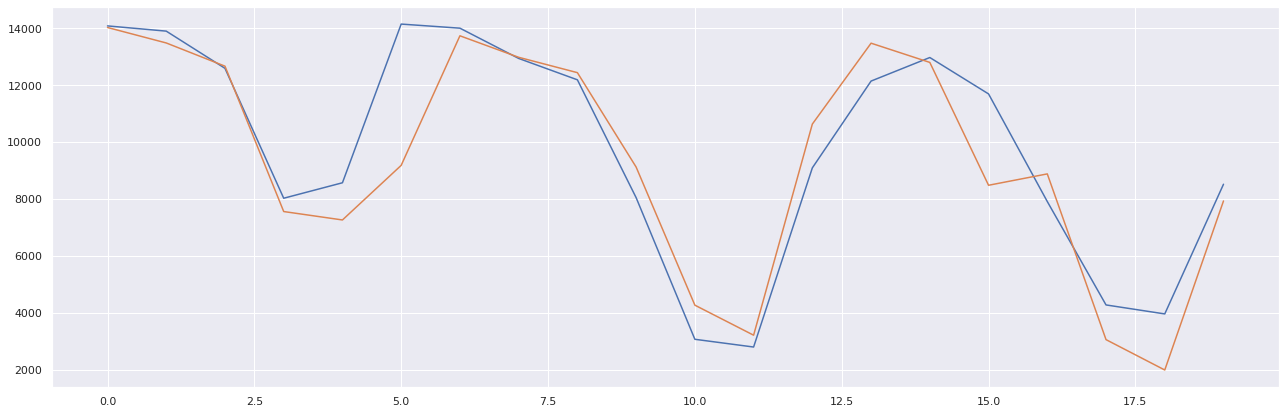

In [40]:
plot_20(Y, y_pred)